# Tutorial on the RUS equations (Rayleigh-Ritz method in code)

Show the tools in that RUS toolbox through a worked example.  This notebook is for learning purposes, therefore you will see lots of visualizations just to take you by the hand across the algorithm.

# Example: The Kiwifruit

This time, the geometry is an ellipsoid elongated in the z-axis direction.  The dimensions of the axes and elastic constants are those typical of a kiwifruit from compressive stress tests. 

I adapted the codes of the [PALab](https://github.com/PALab) for [RUS](https://github.com/PALab/RUS) to reproduce the results. These codes were provided by Zadler et al. (2004) and translated to Python by [Paul Freeman](https://github.com/paul-freeman) in 2015. The functions needed are in the file `rus_tools.py`.  The formula for the spheroid in Zadler et al. (2004) has a typo on the multiplying factor (it should be $\pi/2$ instead of $4\pi$!).

The eigenvalues are related to the resonant frequencies of the object!!!

> **Remember to shutdown the kernel and restarting it to clear the memoization global variables before a new run!!!**

The cell below is an example of a typical forward model: given the elastic parameters and shape of an object, calculate its normal mode frequencies and, if needed, the displacements at a given location on or within it.

In [1]:
# Download a data file from github, if it doesn't exist
# !test ! -f rus_tools.py && wget 'https://raw.githubusercontent.com/edur409/Circumferential-Surface-Waves/main/RUS/rus_tools.py'

In [2]:
%%time
import sys
import scipy
import numpy
import scipy.linalg.lapack as lapack
import scipy.linalg as la
from math import sqrt
import rus_tools as rus

def c_l(lam, mu, rho):
    return 1000*numpy.sqrt((lam + 2*mu)/rho)

def c_t(mu, rho):
    return 1000*numpy.sqrt(mu/rho)

def Lambda(E, nu):
    return E*nu/((1 + nu)*(1 - 2*nu))

def G(E, nu):
    return E/(2*(1 + nu))

E = 4.3*1e-3 # GPa Kiwifruit
nu = 0.4997

# Inputs
# Aluminium: Lam: 53.0989  , Mu: 26.0 , Rho: 2.710
# Copper: Lam: 105.6 GPa, Mu: 48.3 GPa, Rho: 8.933 g/cm^3
Lam = Lambda(E, nu)#105.6 # GPa 53.0989#
Mu = G(E, nu)#48.3 # GPa 26.7195 
rho = 1.100 #8.933 # cm^3 2.710 #

print('Vp: ', c_l(Lam, Mu, rho))
print('Vs: ', c_t(Mu, rho))

# Shape of object and dimensions
shape = 2 # 1 for cylinder.  2 for a sphere
args = {'nfreq': 100, 'outeigen': None}
a = {'c11': Lam + 2*Mu, 'c44': Mu}
dimension1 = 5.00/2 #2.5 # Radius 1 4.422/2 #
dimension2 = 5.00/2 #4.70/2#2.5 # Radius 2 4.422/2 #
dimension3 = 6.5/2 #3.8 # Radius 3  # Use this: 150.0e4 and cylinder shape = 1 for infinite cylinder #6.414/2 #
dimensions = [dimension1, dimension2, dimension3]
print('2*dimension1:', 2*dimension1)
print('2*dimension2:', 2*dimension2)
print('2*dimension3:', 2*dimension3)

# Elastic matrix and stiffness tensor
cm = rus.make_cm(a, hextype=None) # Voigt notation 6X6 array

cijkl = rus.stiffness(cm) # Full tensor 3x3x3x3 array
print('Stress tensor: ',cm)
# print('DATA C/ ',cijkl.reshape(81, order='F')) # Vissher et al. (1991) Fortran code for Cijkl

# Code starts
d = 8 # N order or NN in Vissher et al. 1991
problem_size = int(3*(d + 1)*(d + 2)*(d + 3)/6) # R in Vissher et al. 1991

tabs, irk = rus.index_relationship(d, problem_size)

e = rus.e_fill(tabs, dimensions, rho, shape, irk)

gamma = rus.gamma_fill(tabs, dimensions, cm, shape, irk)

print("done preparing matrices") # It works find until here

jobz = 'N'
if args['outeigen'] == None: #args.outeigen == None:
    jobz = 'N'
else:
    jobz = 'V'

# Solves the eigenproblem for each block of the block-diagonal matrix Gamma
# Each matrix in the block is positive-difinite
w = []
eigvals = []
eigvect = []
for k in range(8):
    # lapack routine
    #w_temp, _, _ = lapack.dsygv(gamma[k], e[k], itype=1, jobz=jobz, uplo='U') 
    w_temp, v_temp = la.eigh(gamma[k], e[k], lower=False, eigvals_only=False, type=1, overwrite_a=True, overwrite_b=True, check_finite=False)
    w.append(w_temp)
    eigvals.append(w_temp)
    eigvect.append(numpy.transpose(v_temp)) # Transpose if needed!

# start eigen vectors (block)
r = problem_size
z = numpy.zeros((r,r)) # Matrix of eigenvectors matching tabs array
irf = 0
for k in range(8):
    for ir1 in range(irf,irf+irk[k]):
        for ir2 in range(irf,irf+irk[k]):
            z[ir2][ir1] = eigvect[k][ir2-irf][ir1-irf]
    for ir1 in range(irk[k]+irf,r):
        for ir2 in range(irf,irf+irk[k]):
            z[ir2][ir1] = 0.0
    irf += irk[k]
# end eigen vectors (block)    

# Sort eigenvalues
wsort = numpy.zeros(problem_size)
i = 0
for k in range(8):
    for ir1 in range(irk[k]):
        wsort[i] = w[k][ir1]
        i += 1
wsort.sort()

# Choose the unique values inside the eigenvalue array
eigenfreqs = numpy.unique(numpy.round(1e5*numpy.sqrt(wsort[6:])/(2.0*numpy.pi), decimals=4))

i = 0
ir1 = 0
while ir1 < args['nfreq']:#args.nfreq:
    ir1 += 1
    print(" f%d = %f" % (ir1, eigenfreqs[i]))
    i += 1


Vp:  1474.2641869755362
Vs:  36.10112132915746
2*dimension1: 5.0
2*dimension2: 5.0
2*dimension3: 6.5
Stress tensor:  [[2.390800382298503, 2.3879331421838135, 2.3879331421838135, 0.0, 0.0, 0.0], [2.3879331421838135, 2.390800382298503, 2.3879331421838135, 0.0, 0.0, 0.0], [2.3879331421838135, 2.3879331421838135, 2.390800382298503, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0014336200573448023, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0014336200573448023, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0014336200573448023]]
irk[0]=75
irk[1]=50
irk[2]=50
irk[3]=60
irk[4]=60
irk[5]=75
irk[6]=75
irk[7]=50
done preparing matrices
 f1 = 448.225100
 f2 = 458.845100
 f3 = 523.550900
 f4 = 550.365300
 f5 = 594.835700
 f6 = 607.250400
 f7 = 717.946700
 f8 = 736.354300
 f9 = 783.131900
 f10 = 786.920700
 f11 = 818.360500
 f12 = 836.382500
 f13 = 846.276400
 f14 = 895.668700
 f15 = 915.009800
 f16 = 917.293500
 f17 = 964.929000
 f18 = 982.902600
 f19 = 1010.732900
 f20 = 1016.833600
 f21 = 1038.587200
 f22 = 1062.414900
 f23 = 11

## The sorted eigenvalues

notice the repetitions of eigenvalues.

In [3]:
numpy.round(1e5*numpy.sqrt(wsort[6:150])/(2.0*numpy.pi), decimals=4)

array([ 448.2251,  458.8451,  458.8451,  523.5509,  550.3653,  550.3653,
        594.8357,  594.8357,  607.2504,  607.2504,  717.9467,  736.3543,
        736.3543,  783.1319,  783.1319,  786.9207,  818.3605,  818.3605,
        836.3825,  836.3825,  846.2764,  846.2764,  895.6687,  895.6687,
        915.0098,  917.2935,  917.2935,  964.929 ,  982.9026,  982.9026,
       1010.7329, 1016.8336, 1016.8336, 1038.5872, 1038.5872, 1062.4149,
       1062.4149, 1105.4645, 1105.4645, 1110.3322, 1110.3322, 1113.1867,
       1113.1867, 1161.1713, 1161.1713, 1167.6815, 1195.8771, 1195.8771,
       1206.2087, 1209.5966, 1209.5966, 1221.2788, 1221.2788, 1229.6878,
       1238.5563, 1238.5563, 1264.4923, 1264.4923, 1270.3893, 1270.3893,
       1276.6989, 1290.508 , 1290.508 , 1312.2002, 1312.2002, 1324.2055,
       1324.2055, 1360.4073, 1360.4073, 1374.2952, 1374.2952, 1394.0884,
       1394.0884, 1411.3181, 1411.3181, 1440.2045, 1445.5317, 1452.2148,
       1452.2148, 1470.1379, 1470.1379, 1474.6586, 

# Organization of the indices for each k

If you want to reconstruct the displacements, you have to keep good track of the 8 individual eigenproblems solved above.  The function `index_relationship` did exactly that.  The matrix $\Gamma$ is a block-diagonal matrix of 8 blocks, therefore the arrays `tabs` and `irk` contain the values and size of the blocks for all the indices.  The plots below will help you visualize the contents of both arrays.

> tabs = (i, l, m, n) of size (R, 4) or (problem_size, 4).
> irk = order or size of the 8 individual blocks, the size is 8 (the number of $k$ values).

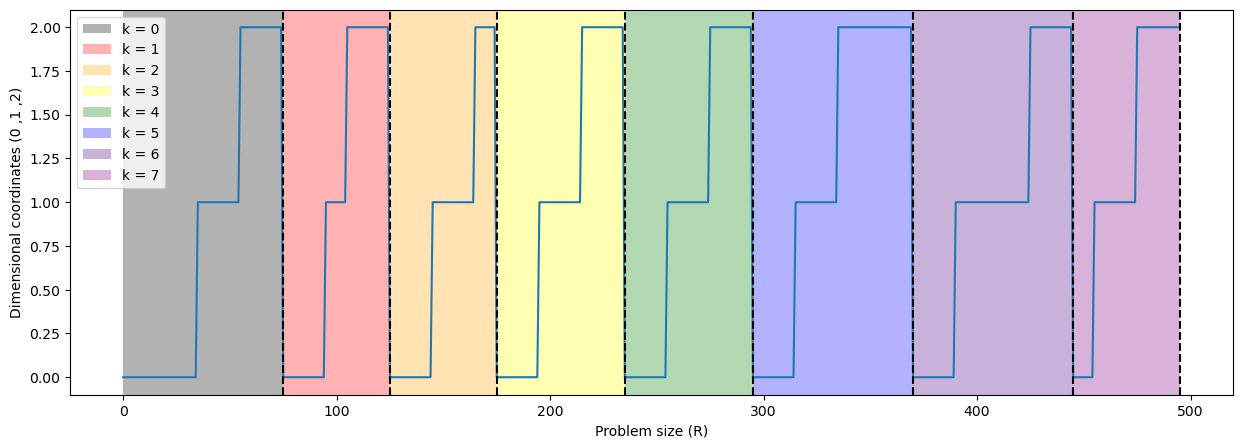

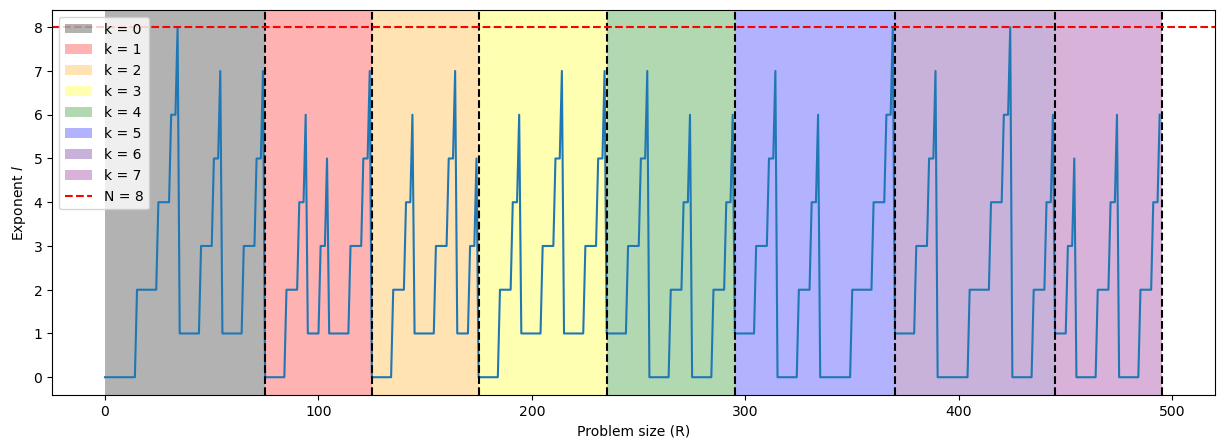

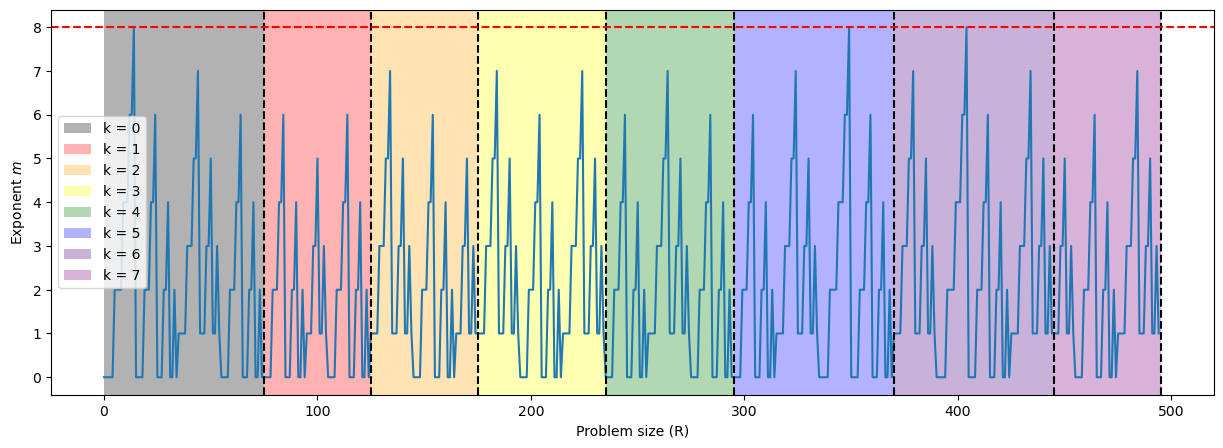

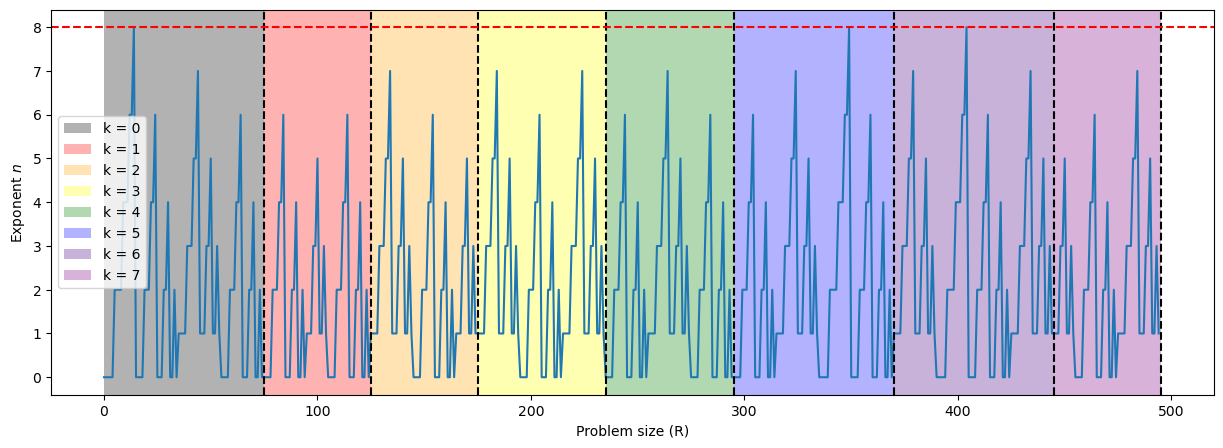

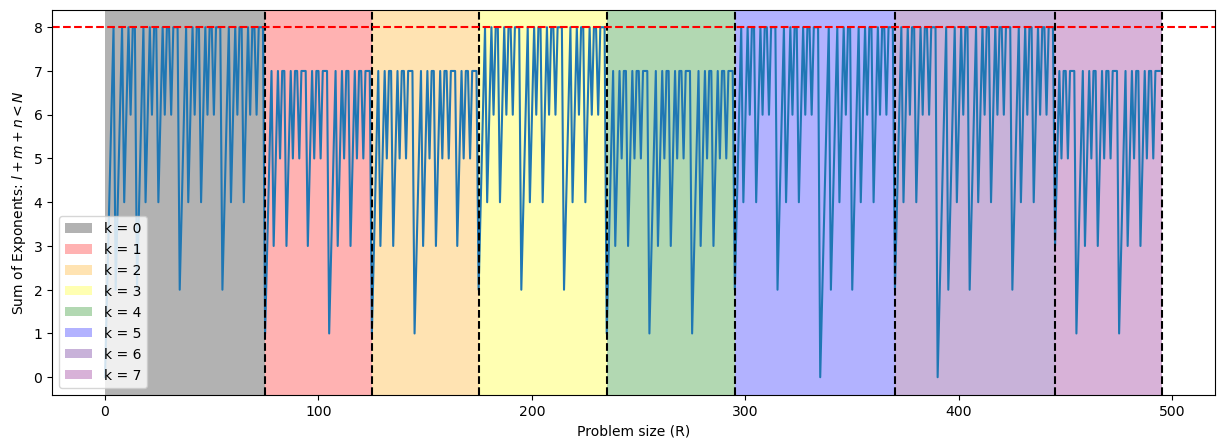

In [4]:
# Understand the tabs array through some plots
import matplotlib.pyplot as plt

block_colors = ['Black','Red', 'Orange', 'Yellow', 'Green', 'Blue', 'Indigo', 'Purple']

plt.figure('Dimensional coordinates', figsize = (15,5))
plt.plot(tabs[:,0])
irkcp = 0
irkc = 0
for k in range(0,len(irk)):
    irkcp = irkc
    irkc = irkc + irk[k]
    plt.axvline(irkc, c = 'k', linestyle ='--')
    plt.axvspan(irkcp ,irkc, facecolor = block_colors[k], alpha = 0.3, label = 'k = '+str(k)+'')
plt.ylabel('Dimensional coordinates (0 ,1 ,2)')
plt.xlabel('Problem size (R)')
plt.legend()

plt.figure('Exponent l', figsize = (15,5))
plt.plot(tabs[:,1])
irkcp = 0
irkc = 0
for k in range(0,len(irk)):
    irkcp = irkc
    irkc = irkc + irk[k]
    plt.axvline(irkc, c = 'k', linestyle ='--')
    plt.axvspan(irkcp ,irkc, facecolor = block_colors[k], alpha = 0.3, label = 'k = '+str(k)+'') 
plt.axhline(d, c = 'r', linestyle ='--', label = 'N = '+str(d)+'')
plt.ylabel('Exponent $l$')
plt.xlabel('Problem size (R)')
plt.legend()

plt.figure('Exponent m', figsize = (15,5))
plt.plot(tabs[:,2])
irkcp = 0
irkc = 0
for k in range(0,len(irk)):
    irkcp = irkc
    irkc = irkc + irk[k]
    plt.axvline(irkc, c = 'k', linestyle ='--')
    plt.axvspan(irkcp ,irkc, facecolor = block_colors[k], alpha = 0.3, label = 'k = '+str(k)+'') 
plt.axhline(d, c = 'r', linestyle ='--')
plt.ylabel('Exponent $m$')
plt.xlabel('Problem size (R)')
plt.legend()

plt.figure('Exponent n', figsize = (15,5))
plt.plot(tabs[:,2])
irkcp = 0
irkc = 0
for k in range(0,len(irk)):
    irkcp = irkc
    irkc = irkc + irk[k]
    plt.axvline(irkc, c = 'k', linestyle ='--')
    plt.axvspan(irkcp ,irkc, facecolor = block_colors[k], alpha = 0.3, label = 'k = '+str(k)+'') 
plt.axhline(d, c = 'r', linestyle ='--')
plt.ylabel('Exponent $n$')
plt.xlabel('Problem size (R)')
plt.legend()

plt.figure('Sum of Exponents l, m , n', figsize = (15,5))
plt.plot(numpy.sum(tabs[:,1:],axis=1))
irkcp = 0
irkc = 0
for k in range(0,len(irk)):
    irkcp = irkc
    irkc = irkc + irk[k]
    plt.axvline(irkc, c = 'k', linestyle ='--')
    plt.axvspan(irkcp ,irkc, facecolor = block_colors[k], alpha = 0.3, label = 'k = '+str(k)+'') 
plt.axhline(d, c = 'r', linestyle ='--')
plt.ylabel('Sum of Exponents: $l + m + n < N$')
plt.xlabel('Problem size (R)')
plt.legend()

In [5]:
def Phi(dimensions, tabs):
    '''
    Calculate the basis function \Phi_{\lambda}, where \lambda contains the indices l, m, n 
    '''
    PHI = []
    #for vals in tabs:
    i, l, m, n = tabs
    PHI = dimensions[0]**l * dimensions[1]**m * dimensions[2]**n
    return PHI 

# Choose a frequency to plot

In [6]:
# Put all the eigenvalues in a long single array
decimals = 10
EIGVALS = numpy.concatenate(eigvals)#/(2*numpy.pi)
# Identify where in this long array a desired frequency repeats
EIGVALS = numpy.round(EIGVALS, decimals = decimals) # Truncate the decimal values to identify the frequencies
# EIGVALS = EIGVALS.sort() # sort the eigenvalues if needed
wsort = numpy.round(wsort, decimals = decimals) # Truncate the decimal values to identify the frequencies
pos = numpy.where(EIGVALS == wsort[6])[0] # Choose a frequency to plot and find its indices!!!
print('Indices where wsort equals the frequency: ', pos)
print('Frequencies: ', 1e5*numpy.sqrt(EIGVALS[pos])/(2*numpy.pi))
# Find the eigenvectors for those eigenvalue positions

Indices where wsort equals the frequency:  [175]
Frequencies:  [448.22507984]


# Plot eigenvalues and eigenvectors

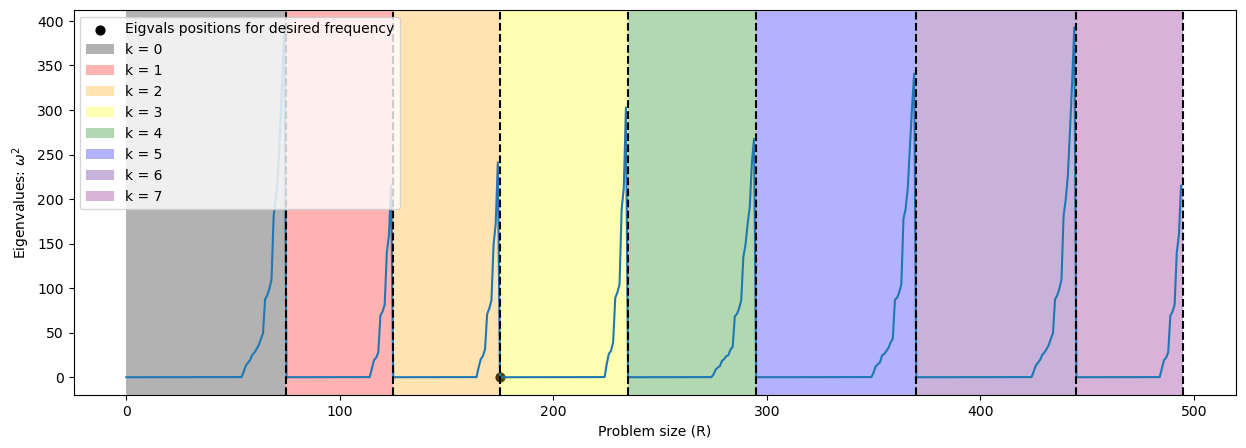

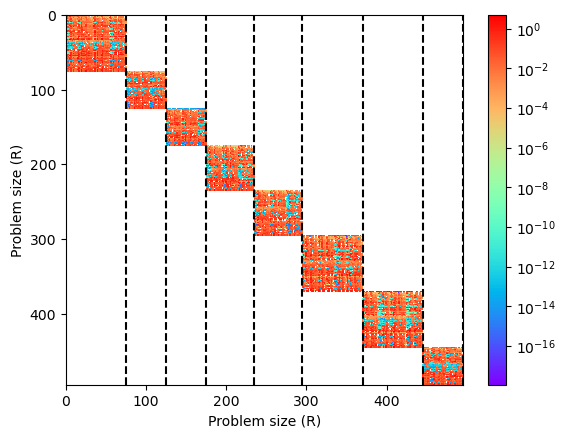

In [7]:
# EIGENVALUES
# Plot the eigenvalues per block
plt.figure('Sum of Exponents l, m , n', figsize = (15,5))
plt.plot(EIGVALS)
plt.scatter(pos, EIGVALS[pos], s = 40, c='k', label = 'Eigvals positions for desired frequency')
irkcp = 0
irkc = 0
irk_lims = [] 
for k in range(0,len(irk)):
    irkcp = irkc
    irkc = irkc + irk[k]
    irk_lims.append(irkc)
    plt.axvline(irkc, c = 'k', linestyle ='--')
    plt.axvspan(irkcp ,irkc, facecolor = block_colors[k], alpha = 0.3, label = 'k = '+str(k)+'') 
plt.ylabel('Eigenvalues: $\omega^2$')
plt.xlabel('Problem size (R)')
plt.legend()

# EIGENVECTORS
# Each of the 8 blocks contains irk[k] eigenvectors 
plt.figure('Eigenvectors')
plt.pcolor(z, cmap = 'rainbow', norm = 'log')
for val in irk_lims:
    plt.axvline(val, c = 'k', linestyle ='--')#, label = 'Block limits')    
plt.xlabel('Problem size (R)')
plt.ylabel('Problem size (R)')
plt.gca().invert_yaxis()
plt.colorbar()
#plt.legend()

In [8]:
def u_i(z, location, pos):
    '''
    Calculates the displacement components for a location on or within the sample material
    z = matrix of eigenvectors.
    pos = index vector of positions where a desired eigenvalue (frequency) is stored
    Attention: if pos is a single value, put it in brackets within the function [pos]
    that way it makes it iterable in python.
    location = [X, Y, Z] position 
    '''    
    dx = 0
    dy = 0
    dz = 0
    for p in pos:
        j = 0
        for tab in tabs:
            i, l, m, n = tab        
            if i == 0:
                dx = dx + z[p,j]*Phi(location, tab) 
            elif i == 1:
                dy = dy + z[p,j]*Phi(location, tab)
            elif i == 2:
                dz = dz + z[p,j]*Phi(location, tab)
            # print(j, i, l, m, n)
            j+=1
    return numpy.array([dx, dy, dz])

# location = [dimension1*numpy.cos(numpy.pi/4), dimension2*numpy.cos(numpy.pi/4) , 0] # -dimension1*numpy.cos(numpy.pi/4),-dimension2*numpy.cos(numpy.pi/4)
# dx, dy, dz = u_i(z, location, [pos[1]]) # pos[2] is in k = 5 (Volume oscillates)

# du=numpy.array([dx,dy,dz])
# du_n = du/numpy.linalg.norm(du)
# print('Norm vector: ',du_n)

# Plot the outline of the equator

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def ellipsoid_boundary_axial_plane(a, b, c, plane):
    """
    Calculate the boundary coordinates of the intersection ellipse of a triaxial ellipsoid
    with a specified axial plane.

    Parameters:
    a (float): Semi-axis length along x-axis
    b (float): Semi-axis length along y-axis
    c (float): Semi-axis length along z-axis
    plane (str): Specifies the axial plane ('xy', 'xz', 'yz')

    Returns:
    numpy.ndarray: Array of shape (num_points, 3) containing the (x, y, z) coordinates of the ellipse boundary
    """
    num_points = 100
    theta = np.linspace(0, 2 * np.pi, num_points)
    
    if plane == 'xy':
        # Intersection with the xy-plane (z = 0)
        a_prime = a
        b_prime = b
        x = a_prime * np.cos(theta)
        y = b_prime * np.sin(theta)
        z = np.zeros_like(x)
        coords = np.vstack((x, y, z)).T
    
    elif plane == 'xz':
        # Intersection with the xz-plane (y = 0)
        a_prime = a
        c_prime = c
        x = a_prime * np.cos(theta)
        z = c_prime * np.sin(theta)
        y = np.zeros_like(x)
        coords = np.vstack((x, y, z)).T
    
    elif plane == 'yz':
        # Intersection with the yz-plane (x = 0)
        b_prime = b
        c_prime = c
        y = b_prime * np.cos(theta)
        z = c_prime * np.sin(theta)
        x = np.zeros_like(y)
        coords = np.vstack((x, y, z)).T
    
    else:
        raise ValueError("Invalid plane type. Choose from 'xy', 'xz', or 'yz'.")
    
    return coords


(np.float64(-2.7486784237558606),
 np.float64(2.749937067797898),
 np.float64(-3.5745500064341034),
 np.float64(3.5745500064341034))

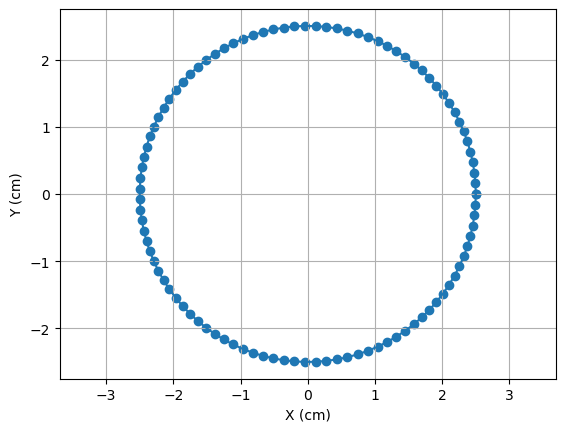

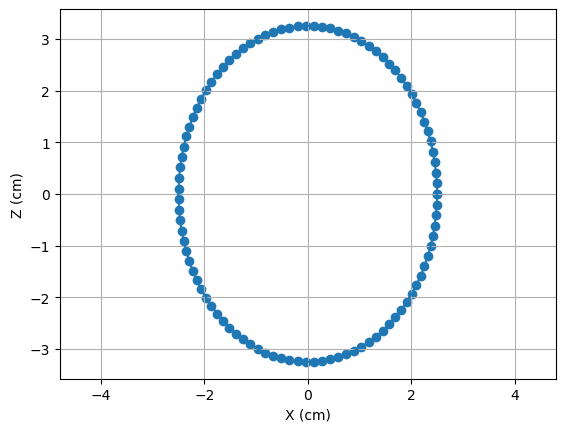

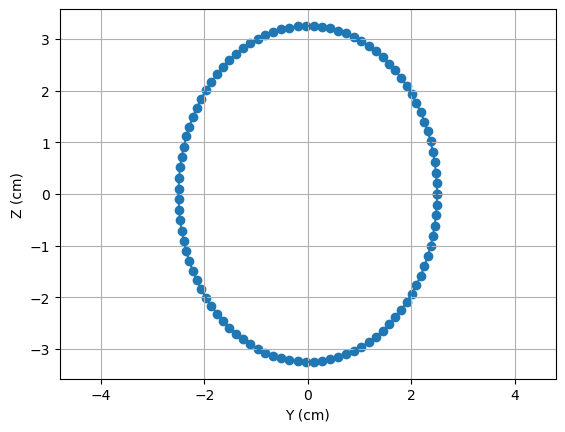

In [10]:
# XY-plane
locations_xy = ellipsoid_boundary_axial_plane(dimension1, dimension2, dimension3, 'xy')

plt.figure('XY')
plt.plot(locations_xy[:,0], locations_xy[:,1])
plt.scatter(locations_xy[:,0], locations_xy[:,1])
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
plt.grid(True)
plt.axis('equal')

locations_xz = ellipsoid_boundary_axial_plane(dimension1, dimension2, dimension3, 'xz')
plt.figure('XZ')
plt.plot(locations_xz[:,0], locations_xz[:,2])
plt.scatter(locations_xz[:,0], locations_xz[:,2])
plt.xlabel('X (cm)')
plt.ylabel('Z (cm)')
plt.grid(True)
plt.axis('equal')

locations_yz = ellipsoid_boundary_axial_plane(dimension1, dimension2, dimension3, 'yz')
plt.figure('YZ')
plt.plot(locations_yz[:,1], locations_yz[:,2])
plt.scatter(locations_yz[:,1], locations_yz[:,2])
plt.xlabel('Y (cm)')
plt.ylabel('Z (cm)')
plt.grid(True)
plt.axis('equal')

# Plot the vectors for a particular frequency on the equator

The code in the next cell performs three steps:

1) Find where a particular frequency occurs in our sorted eigenvalues vector (`wsort`).
```python
pos = numpy.where(EIGVALS == wsort[11])[0] # Choose a frequency to plot and find its indices!!!
print('Indices where wsort equals the frequency: ', pos)
print('Frequencies: ', 1e5*numpy.sqrt(EIGVALS[pos])/(2*numpy.pi))
```

2) Calculate the displacements for one of those particular frequencies around the equator locations defined before
```python
DU = numpy.zeros((len(locations),2))
i = 0
for loc in locations:
    dx, dy, dz = u_i(z, [loc[0], loc[1], 0], [pos[4]]) # pos: use all positions, otherwise choose a particular one (e.g. [pos[3]])
    du=numpy.array([dx,dy,dz])
    du_n = du/numpy.linalg.norm(du)
    DU[i,0] = du_n[0]
    DU[i,1] = du_n[1]
    i+=1
```

3) Plot the displacement vectors
```python
plt.figure('Displacements')
plt.plot(locations[:,0], locations[:,1])
plt.scatter(locations[:,0], locations[:,1])
for i in range(0,len(locations)):
    plt.quiver(locations[i,0], locations[i,1], DU[i,0], DU[i,1])
plt.grid(True)
plt.axis('equal')
```

The cell below calculates the displacements and plots them for many frequencies around the equator of the fruit.  The figures are saved in the folder `figures`.  A similar calculation can be reproduced and visualized using [Lucien Saviot's online tool](https://saviot.cnrs.fr/rus/tri/index.en.html#nx=2&ny=0.2&nz=10&nx2=2&ny2=2&nz2=2&dx=3&dy=5&dz=3&dx2=7&dy2=5&dz2=7&rho=19.283&C=191,162,162,0,0,0,191,162,0,0,0,191,0,0,0,42.4,0,0,42.4,0,42.4&nn=6&unit=-9). 

In [11]:
for eig in range(6,150):
    pos = numpy.where(EIGVALS == wsort[eig])[0] # Choose a frequency to plot and find its indices!!! # 9 seems to be a breathing mode, 12, 13 prolate-oblate, 16 Y-plane, 19, 28-tri-mode
    print('Indices where wsort equals the frequency: ', pos)
    print('Frequencies: ', 1e5*numpy.sqrt(EIGVALS[pos])/(2*numpy.pi))
    
    freq = pos[0]
    
    # XY-plane
    DU = numpy.zeros((len(locations_xy),2))
    i = 0
    for loc in locations_xy:
        dx, dy, dz = u_i(z, loc, pos) # pos: use all positions, otherwise choose a particular one (e.g. [pos[3]])
        du=numpy.array([dx,dy,dz])
        du_n = du/numpy.linalg.norm(du)
        DU[i,0] = du_n[0]
        DU[i,1] = du_n[1]
        i+=1
    
    plt.figure('Displacements')
    plt.title('XY-plane ('+str(numpy.round(1e5*numpy.sqrt(EIGVALS[pos[0]])/(2*numpy.pi)))+' Hz)')
    plt.plot(locations_xy[:,0], locations_xy[:,1])
    plt.scatter(locations_xy[:,0], locations_xy[:,1])
    for i in range(0,len(locations_xy)):
        plt.quiver(locations_xy[i,0], locations_xy[i,1], DU[i,0], DU[i,1])
    plt.xlabel('X (cm)')
    plt.ylabel('Y (cm)')
    plt.grid(True)
    plt.axis('equal')
    plt.savefig('./figures/XY_eigenvalue_'+str(eig)+'.png')
    plt.clf()

Indices where wsort equals the frequency:  [175]
Frequencies:  [448.22507984]


C:\Users\edur409\AppData\Local\Temp\ipykernel_15616\489124118.py:14: RuntimeWarning: invalid value encountered in divide
  du_n = du/numpy.linalg.norm(du)
C:\ProgramData\Anaconda3\envs\pyGIS\Lib\site-packages\matplotlib\quiver.py:630: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
C:\ProgramData\Anaconda3\envs\pyGIS\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\envs\pyGIS\Lib\site-packages\matplotlib\quiver.py:649: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\ProgramData\Anaconda3\envs\pyGIS\Lib\site-packages\matplotlib\quiver.py:649: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Indices where wsort equals the frequency:  [  1 371]
Frequencies:  [458.84508105 458.84508105]
Indices where wsort equals the frequency:  [  1 371]
Frequencies:  [458.84508105 458.84508105]
Indices where wsort equals the frequency:  [235]
Frequencies:  [523.55092011]
Indices where wsort equals the frequency:  [ 76 446]
Frequencies:  [550.36531827 550.36531827]
Indices where wsort equals the frequency:  [ 76 446]
Frequencies:  [550.36531827 550.36531827]
Indices where wsort equals the frequency:  [126 236]
Frequencies:  [594.83567538 594.83567538]
Indices where wsort equals the frequency:  [126 236]
Frequencies:  [594.83567538 594.83567538]
Indices where wsort equals the frequency:  [176 296]
Frequencies:  [607.25036176 607.25036176]
Indices where wsort equals the frequency:  [176 296]
Frequencies:  [607.25036176 607.25036176]
Indices where wsort equals the frequency:  [127]
Frequencies:  [717.94673107]
Indices where wsort equals the frequency:  [ 77 447]
Frequencies:  [736.35433403 736

<Figure size 640x480 with 0 Axes>

(np.float64(-2.7486784237558606),
 np.float64(2.749937067797898),
 np.float64(-3.5745500064341034),
 np.float64(3.5745500064341034))

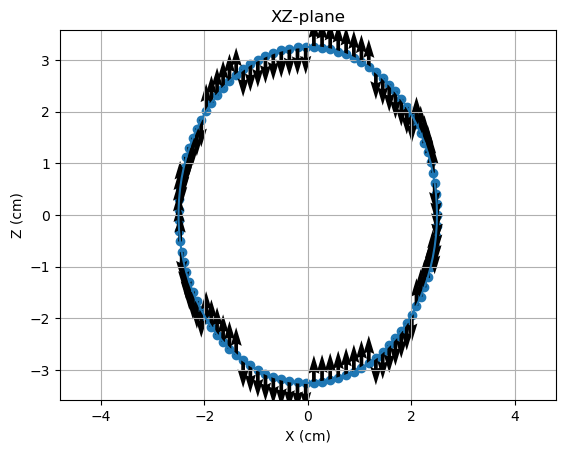

In [12]:
# XZ-plane
DU = numpy.zeros((len(locations_xz),2))
i = 0
for loc in locations_xz:
    dx, dy, dz = u_i(z, loc, pos) # pos: use all positions, otherwise choose a particular one (e.g. [pos[3]])
    du=numpy.array([dx,dy,dz])
    du_n = du/numpy.linalg.norm(du)
    DU[i,0] = du_n[0]
    DU[i,1] = du_n[1]
    i+=1

plt.figure('Displacements')
plt.title('XZ-plane')
plt.plot(locations_xz[:,0], locations_xz[:,2])
plt.scatter(locations_xz[:,0], locations_xz[:,2])
for i in range(0,len(locations_xz)):
    plt.quiver(locations_xz[i,0], locations_xz[i,2], DU[i,0], DU[i,1])
plt.xlabel('X (cm)')
plt.ylabel('Z (cm)')
plt.grid(True)
plt.axis('equal')

(np.float64(-2.7486784237558606),
 np.float64(2.749937067797898),
 np.float64(-3.5745500064341034),
 np.float64(3.5745500064341034))

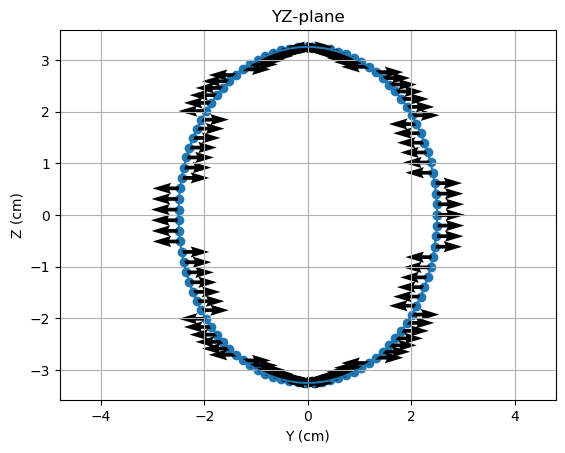

In [13]:
# YZ-plane
DU = numpy.zeros((len(locations_yz),2))
i = 0
for loc in locations_yz:
    dx, dy, dz = u_i(z, loc, pos) # pos: use all positions, otherwise choose a particular one (e.g. [pos[3]])
    du=numpy.array([dx,dy,dz])
    du_n = du/numpy.linalg.norm(du)
    DU[i,0] = du_n[0]
    DU[i,1] = du_n[1]
    i+=1

plt.figure('Displacements')
plt.title('YZ-plane')
plt.plot(locations_yz[:,1], locations_yz[:,2])
plt.scatter(locations_yz[:,1], locations_yz[:,2])
for i in range(0,len(locations_yz)):
    plt.quiver(locations_yz[i,1], locations_yz[i,2], DU[i,0], DU[i,1])
plt.xlabel('Y (cm)')
plt.ylabel('Z (cm)')
plt.grid(True)
plt.axis('equal')

# References

- Visscher, W. M., Migliori, A., Bell, T. M., & Reinert, R. A. (1991). On the normal modes of free vibration of inhomogeneous and anisotropic elastic objects. The Journal of the Acoustical Society of America, 90(4), 2154-2162.
- Migliori, A., Sarrao, J. L., Visscher, W. M., Bell, T. M., Lei, M., Fisk, Z., & Leisure, R. G. (1993). Resonant ultrasound spectroscopic techniques for measurement of the elastic moduli of solids. Physica B: Condensed Matter, 183(1-2), 1-24.
- de Rue, J. (1996). On the normal modes of freely vibrating elastic objects of various shapes (MSc thesis, University of Amsterdam).
- Zadler, B. J., Le Rousseau, J. H., Scales, J. A., & Smith, M. L. (2004). Resonant ultrasound spectroscopy: theory and application. Geophysical Journal International, 156(1), 154-169.